In [ ]:
!pip install PrettyTable praw matplotlib vaderSentiment


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip



Enter two keywords to compare (or 'quit' to exit):

Analyzing Reddit posts...

ME Search for 'twisters 2024' vs 'longlegs 2024' on Reddit
Posts analyzed: twisters 2024: 50, longlegs 2024: 50
+-----------+---------------------+---------------------+
| Sentiment | twisters 2024 Count | longlegs 2024 Count |
+-----------+---------------------+---------------------+
|  Positive |          83         |          88         |
|  Neutral  |          79         |          74         |
|  Negative |          28         |          44         |
+-----------+---------------------+---------------------+

Sentiment Percentages:
+-----------+--------------------------+--------------------------+
| Sentiment | twisters 2024 Percentage | longlegs 2024 Percentage |
+-----------+--------------------------+--------------------------+
|  Positive |          43.68%          |          42.72%          |
|  Neutral  |          41.58%          |          35.92%          |
|  Negative |          14.74%         

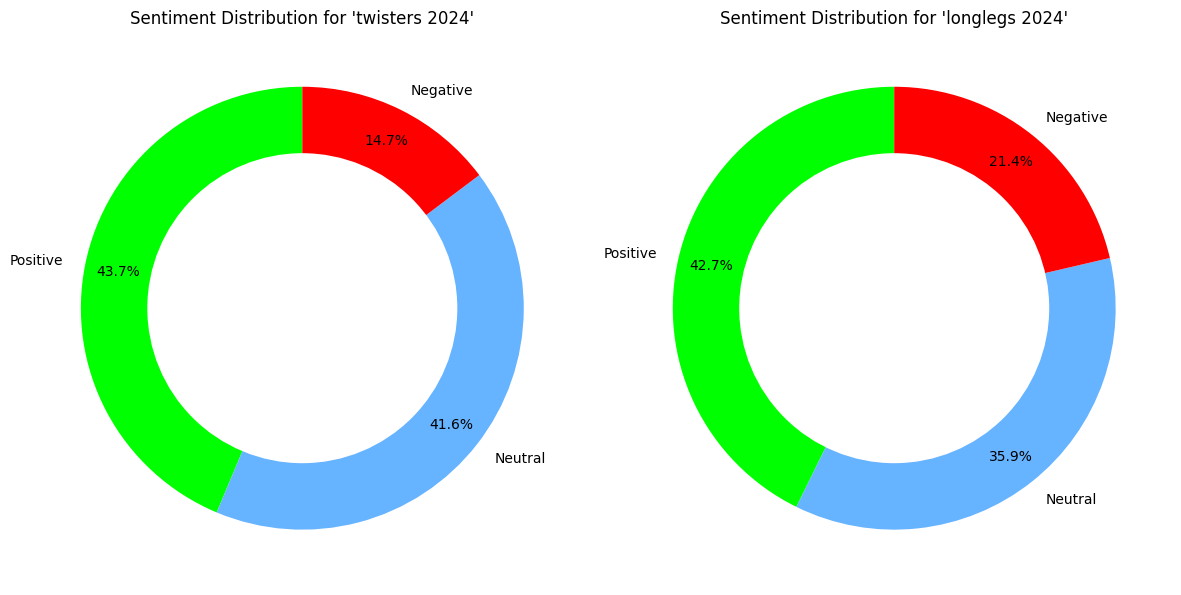


Posts for 'twisters 2024':
1. 'Twisters' Review Thread (Sentiment: neutral)
2. Set image for 'Twisters' (2024) (Sentiment: neutral)
3. Twisters (1996) made the equivalent of a billion 2024 dollars when it came out, how much do you think Twisters (2024) will make? (Sentiment: neutral)
4. Predictions for the Twisters (2024) Movie (Sentiment: neutral)
5. Why Twisters (2024) Will Fail (Sentiment: negative)
6. I'm calling it now, there'll be a plot twist at the end of Twisters (2024) (Sentiment: neutral)
7. Every Twister Masquerade Mask (Killer) 2024  (Sentiment: negative)
8. Twisters (2024) selfie (Sentiment: neutral)
9. In the poster for Twisters (2024) there is only one twister (Sentiment: neutral)
10. Twisters (2024) Trailer - Starring Daisy Edgar-Jones, Glen Powell (Sentiment: neutral)
11. ‘Twister’ Sequel Sets Summer 2024 Release Date (Sentiment: neutral)
12. Twisters (2024) (Sentiment: neutral)
13. Twisters (2024) (Sentiment: neutral)
14. Twisters (2024) Textless (Sentiment: neutral

KeyboardInterrupt: Interrupted by user

In [ ]:
import praw
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# Reddit API credentials (Replace with your own)
reddit = praw.Reddit(client_id="9XMFqbSv3t9R0eaIwdYJjg",
                     client_secret="U1N76Gdwn-MeWI318YvQSANN8ejMzw",
                     user_agent="script:negafied:v1.0 (by /u/EducationalPlum4736)")

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def clean_text(text):
    """Clean text by removing links and special characters"""
    return ' '.join(re.sub("(https?:\/\/\S+)", "", text).split())

def analyze_sentiment(text):
    """Analyze sentiment using VADER"""
    cleaned_text = clean_text(text)
    scores = sid.polarity_scores(cleaned_text)
    
    # Determine overall sentiment
    if scores['compound'] > 0.05:
        sentiment = 'positive'
    elif scores['compound'] < -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment, scores

def social_listen(keyword, count=100):
    """Perform social listening on a given keyword"""
    subreddit = reddit.subreddit("all")
    posts = subreddit.search(keyword, limit=None)
    
    sentiments = Counter()
    subreddits = Counter()
    analyzed_posts = 0
    post_data = []
    
    for post in posts:
        if analyzed_posts >= count:
            break
        
        # Analyze post title
        sentiment, scores = analyze_sentiment(post.title)
        sentiments[sentiment] += 1
        
        # Count subreddit
        subreddits[post.subreddit.display_name] += 1
        
        # Store post data
        post_data.append({
            'title': post.title,
            'author': post.author.name if post.author else '[deleted]',
            'url': post.url,
            'subreddit': post.subreddit.display_name,
            'sentiment': sentiment,
            'vader_scores': scores
        })
        
        # Analyze top-level comments
        post.comments.replace_more(limit=0)  # Only fetch existing comments
        for comment in post.comments.list()[:5]:  # Analyze up to 5 top-level comments
            comment_sentiment, _ = analyze_sentiment(comment.body)
            sentiments[comment_sentiment] += 1
        
        analyzed_posts += 1
    
    return sentiments, subreddits, analyzed_posts, post_data

def calculate_percentages(sentiments):
    """Calculate percentage for each sentiment"""
    total = sum(sentiments.values())
    return {sentiment: (count / total) * 100 for sentiment, count in sentiments.items()}

def calculate_x_score(percentages):
    """Calculate X-score based on sentiment percentages"""
    positive = percentages.get('positive', 0)
    neutral = percentages.get('neutral', 0)
    negative = percentages.get('negative', 0)
    return ((positive * 5 + neutral - negative * 8))

def get_grade(x_score):
    """Get grade based on X-score"""
    if x_score >= 200:
        return 'SSS'
    elif x_score >=150:
        return 'SS'
    elif x_score >= 97:
        return 'S'
    elif x_score >= 93:
        return 'A'
    elif x_score >= 86:
        return 'B+'
    elif x_score >= 78:
        return 'B'
    elif x_score >= 73:
        return 'C+'
    elif x_score >= 67:
        return 'C'
    elif x_score >= 60:
        return 'D'
    else:
        return 'F'

def get_reliability(posts_analyzed):
    """Get reliability based on number of posts analyzed"""
    if posts_analyzed >= 1000:
        return 'Extremely High'
    elif posts_analyzed >= 100:
        return 'High'
    elif posts_analyzed >= 11:
        return 'Medium'
    else:
        return 'Low'

def display_comparative_results(keyword1, keyword2, results1, results2):
    """Display comparative results in a clean interface"""
    sentiments1, subreddits1, posts1, post_data1 = results1
    sentiments2, subreddits2, posts2, post_data2 = results2
    
    print(f"\nME Search for '{keyword1}' vs '{keyword2}' on Reddit")
    print("=" * 70)
    
    print(f"Posts analyzed: {keyword1}: {posts1}, {keyword2}: {posts2}")
    
    # Sentiment Table
    sentiment_table = PrettyTable()
    sentiment_table.field_names = ["Sentiment", f"{keyword1} Count", f"{keyword2} Count"]
    for sentiment in set(sentiments1.keys()) | set(sentiments2.keys()):
        sentiment_table.add_row([
            sentiment.capitalize(),
            sentiments1.get(sentiment, 0),
            sentiments2.get(sentiment, 0)
        ])
    print(sentiment_table)
    
    # Sentiment Percentage Table
    percentages1 = calculate_percentages(sentiments1)
    percentages2 = calculate_percentages(sentiments2)
    percentage_table = PrettyTable()
    percentage_table.field_names = ["Sentiment", f"{keyword1} Percentage", f"{keyword2} Percentage"]
    for sentiment in set(percentages1.keys()) | set(percentages2.keys()):
        percentage_table.add_row([
            sentiment.capitalize(),
            f"{percentages1.get(sentiment, 0):.2f}%",
            f"{percentages2.get(sentiment, 0):.2f}%"
        ])
    print("\nSentiment Percentages:")
    print(percentage_table)
    
    # X-score and Grade
    x_score1 = calculate_x_score(percentages1)
    x_score2 = calculate_x_score(percentages2)
    grade1 = get_grade(x_score1)
    grade2 = get_grade(x_score2)
    reliability1 = get_reliability(posts1)
    reliability2 = get_reliability(posts2)
    
    x_score_table = PrettyTable()
    x_score_table.field_names = ["Metric", keyword1, keyword2]
    x_score_table.add_row(["X-score", f"{x_score1:.2f}", f"{x_score2:.2f}"])
    x_score_table.add_row(["Grade", grade1, grade2])
    x_score_table.add_row(["Reliability", reliability1, reliability2])
    print("\nX-score, Grade, and Reliability:")
    print(x_score_table)
    
    # Top Subreddits Table
    print("\nTop Subreddits:")
    subreddit_table = PrettyTable()
    subreddit_table.field_names = ["Subreddit", f"{keyword1} Count", f"{keyword2} Count"]
    top_subreddits = set(dict(subreddits1.most_common(1000)).keys()) | set(dict(subreddits2.most_common(1000)).keys())
    for subreddit in top_subreddits:
        subreddit_table.add_row([
            subreddit,
            subreddits1.get(subreddit, 0),
            subreddits2.get(subreddit, 0)
        ])
    print(subreddit_table)
    
    return post_data1, post_data2

def display_post_list(keyword, post_data):
    """Display a list of posts for a keyword"""
    print(f"\nPosts for '{keyword}':")
    for i, post in enumerate(post_data, 1):
        print(f"{i}. {post['title']} (Sentiment: {post['sentiment']})")
    
    while True:
        try:
            choice = int(input("\nEnter the number of the post you want to view (0 to go back): "))
            if choice == 0:
                break
            if 1 <= choice <= len(post_data):
                post = post_data[choice - 1]
                print("\nPost Details:")
                print(f"Title: {post['title']}")
                print(f"Author: {post['author']}")
                print(f"Subreddit: {post['subreddit']}")
                print(f"URL: {post['url']}")
                input("\nPress Enter to continue...")
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def create_sentiment_donut_charts(keyword1, keyword2, sentiments1, sentiments2):
    percentages1 = calculate_percentages(sentiments1)
    percentages2 = calculate_percentages(sentiments2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    def create_donut(ax, percentages, keyword):
        labels = ['Positive', 'Neutral', 'Negative']
        sizes = [percentages.get(label.lower(), 0) for label in labels]
        colors = ['#00FF00', '#66b3ff', '#FF0000']

        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
        centre_circle = plt.Circle((0, 0), 0.70, fc='white')
        ax.add_artist(centre_circle)
        ax.set_title(f"Sentiment Distribution for '{keyword}'")

    create_donut(ax1, percentages1, keyword1)
    create_donut(ax2, percentages2, keyword2)

    plt.tight_layout()
    plt.show()

def main():
    while True:
        print("\nEnter two keywords to compare (or 'quit' to exit):")
        keyword1 = input("Keyword 1: ")
        if keyword1.lower() == 'quit':
            break
        keyword2 = input("Keyword 2: ")
        if keyword2.lower() == 'quit':
            break
        
        count = int(input("Enter the number of posts to analyze for each keyword: "))
        
        print("\nAnalyzing Reddit posts...")
        results1 = social_listen(keyword1, count)
        results2 = social_listen(keyword2, count)
        post_data1, post_data2 = display_comparative_results(keyword1, keyword2, results1, results2)
        
        create_sentiment_donut_charts(keyword1, keyword2, results1[0], results2[0])

        while True:
            choice = input("\nEnter '1' to view posts for keyword 1, '2' for keyword 2, or 'b' to go back: ").lower()
            if choice == '1':
                display_post_list(keyword1, post_data1)
            elif choice == '2':
                display_post_list(keyword2, post_data2)
            elif choice == 'b':
                break
            else:
                print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()

In [ ]:
import praw
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# Reddit API credentials (Replace with your own)
reddit = praw.Reddit(client_id="9XMFqbSv3t9R0eaIwdYJjg",
                     client_secret="U1N76Gdwn-MeWI318YvQSANN8ejMzw",
                     user_agent="script:negafied:v1.0 (by /u/EducationalPlum4736)")

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def clean_text(text):
    """Clean text by removing links and special characters"""
    return ' '.join(re.sub("(https?:\/\/\S+)", "", text).split())

def analyze_sentiment(text):
    """Analyze sentiment using VADER"""
    cleaned_text = clean_text(text)
    scores = sid.polarity_scores(cleaned_text)
    
    # Determine overall sentiment
    if scores['compound'] > 0.05:
        sentiment = 'positive'
    elif scores['compound'] < -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment, scores

def social_listen(keyword, count=100):
    """Perform social listening on a given keyword"""
    subreddit = reddit.subreddit("all")
    posts = subreddit.search(keyword, limit=None)
    
    sentiments = Counter()
    subreddits = Counter()
    analyzed_posts = 0
    post_data = []
    
    for post in posts:
        if analyzed_posts >= count:
            break
        
        # Analyze post title
        sentiment, scores = analyze_sentiment(post.title)
        sentiments[sentiment] += 1
        
        # Count subreddit
        subreddits[post.subreddit.display_name] += 1
        
        # Store post data
        post_data.append({
            'title': post.title,
            'author': post.author.name if post.author else '[deleted]',
            'url': post.url,
            'subreddit': post.subreddit.display_name,
            'sentiment': sentiment,
            'vader_scores': scores
        })
        
        # Analyze top-level comments
        post.comments.replace_more(limit=0)  # Only fetch existing comments
        for comment in post.comments.list()[:5]:  # Analyze up to 5 top-level comments
            comment_sentiment, _ = analyze_sentiment(comment.body)
            sentiments[comment_sentiment] += 1
        
        analyzed_posts += 1
    
    return sentiments, subreddits, analyzed_posts, post_data

def calculate_percentages(sentiments):
    """Calculate percentage for each sentiment"""
    total = sum(sentiments.values())
    return {sentiment: (count / total) * 100 for sentiment, count in sentiments.items()}

def calculate_x_score(percentages):
    """Calculate X-score based on sentiment percentages"""
    positive = percentages.get('positive', 0)
    neutral = percentages.get('neutral', 0)
    negative = percentages.get('negative', 0)
    return ((positive * 5 + neutral - negative * 8))

def get_grade(x_score):
    """Get grade based on X-score"""
    if x_score >= 150
        return 'SSS'
    elif x_score >=100:
        return 'SS'
    elif x_score >= 97:
        return 'S'
    elif x_score >= 93:
        return 'A'
    elif x_score >= 86:
        return 'B+'
    elif x_score >= 78:
        return 'B'
    elif x_score >= 73:
        return 'C+'
    elif x_score >= 67:
        return 'C'
    elif x_score >= 60:
        return 'D'
    else:
        return 'F'

def get_reliability(posts_analyzed):
    """Get reliability based on number of posts analyzed"""
    if posts_analyzed >= 1000:
        return 'Extreme'
    elif posts_analyzed >= 100:
        return 'High'
    elif posts_analyzed >= 11:
        return 'Medium'
    else:
        return 'Low'

def display_comparative_results(keyword1, keyword2, results1, results2):
    """Display comparative results in a clean interface"""
    sentiments1, subreddits1, posts1, post_data1 = results1
    sentiments2, subreddits2, posts2, post_data2 = results2
    
    print(f"\nME Search for '{keyword1}' vs '{keyword2}' on Reddit")
    print("=" * 70)
    
    print(f"Posts analyzed: {keyword1}: {posts1}, {keyword2}: {posts2}")
    
    # Sentiment Table
    sentiment_table = PrettyTable()
    sentiment_table.field_names = ["Sentiment", f"{keyword1} Count", f"{keyword2} Count"]
    for sentiment in set(sentiments1.keys()) | set(sentiments2.keys()):
        sentiment_table.add_row([
            sentiment.capitalize(),
            sentiments1.get(sentiment, 0),
            sentiments2.get(sentiment, 0)
        ])
    print(sentiment_table)
    
    # Sentiment Percentage Table
    percentages1 = calculate_percentages(sentiments1)
    percentages2 = calculate_percentages(sentiments2)
    percentage_table = PrettyTable()
    percentage_table.field_names = ["Sentiment", f"{keyword1} Percentage", f"{keyword2} Percentage"]
    for sentiment in set(percentages1.keys()) | set(percentages2.keys()):
        percentage_table.add_row([
            sentiment.capitalize(),
            f"{percentages1.get(sentiment, 0):.2f}%",
            f"{percentages2.get(sentiment, 0):.2f}%"
        ])
    print("\nSentiment Percentages:")
    print(percentage_table)
    
    # X-score and Grade
    x_score1 = calculate_x_score(percentages1)
    x_score2 = calculate_x_score(percentages2)
    grade1 = get_grade(x_score1)
    grade2 = get_grade(x_score2)
    reliability1 = get_reliability(posts1)
    reliability2 = get_reliability(posts2)
    
    x_score_table = PrettyTable()
    x_score_table.field_names = ["Metric", keyword1, keyword2]
    x_score_table.add_row(["X-score", f"{x_score1:.2f}", f"{x_score2:.2f}"])
    x_score_table.add_row(["Grade", grade1, grade2])
    x_score_table.add_row(["Reliability", reliability1, reliability2])
    print("\nX-score, Grade, and Reliability:")
    print(x_score_table)
    
    # Top Subreddits Table
    print("\nTop Subreddits:")
    subreddit_table = PrettyTable()
    subreddit_table.field_names = ["Subreddit", f"{keyword1} Count", f"{keyword2} Count"]
    top_subreddits = set(dict(subreddits1.most_common(1000)).keys()) | set(dict(subreddits2.most_common(1000)).keys())
    for subreddit in top_subreddits:
        subreddit_table.add_row([
            subreddit,
            subreddits1.get(subreddit, 0),
            subreddits2.get(subreddit, 0)
        ])
    print(subreddit_table)
    
    return post_data1, post_data2

def display_post_list(keyword, post_data):
    """Display a list of posts for a keyword"""
    print(f"\nPosts for '{keyword}':")
    for i, post in enumerate(post_data, 1):
        print(f"{i}. {post['title']} (Sentiment: {post['sentiment']})")
    
    while True:
        try:
            choice = int(input("\nEnter the number of the post you want to view (0 to go back): "))
            if choice == 0:
                break
            if 1 <= choice <= len(post_data):
                post = post_data[choice - 1]
                print("\nPost Details:")
                print(f"Title: {post['title']}")
                print(f"Author: {post['author']}")
                print(f"Subreddit: {post['subreddit']}")
                print(f"URL: {post['url']}")
                input("\nPress Enter to continue...")
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def create_sentiment_donut_charts(keyword1, keyword2, sentiments1, sentiments2):
    percentages1 = calculate_percentages(sentiments1)
    percentages2 = calculate_percentages(sentiments2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    def create_donut(ax, percentages, keyword):
        labels = ['Positive', 'Neutral', 'Negative']
        sizes = [percentages.get(label.lower(), 0) for label in labels]
        colors = ['#00FF00', '#66b3ff', '#FF0000']

        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
        centre_circle = plt.Circle((0, 0), 0.70, fc='white')
        ax.add_artist(centre_circle)
        ax.set_title(f"Sentiment Distribution for '{keyword}'")

    create_donut(ax1, percentages1, keyword1)
    create_donut(ax2, percentages2, keyword2)

    plt.tight_layout()
    plt.show()

def main():
    while True:
        print("\nEnter two keywords to compare (or 'quit' to exit):")
        keyword1 = input("Keyword 1: ")
        if keyword1.lower() == 'quit':
            break
        keyword2 = input("Keyword 2: ")
        if keyword2.lower() == 'quit':
            break
        
        count = int(input("Enter the number of posts to analyze for each keyword: "))
        
        print("\nAnalyzing Reddit posts...")
        results1 = social_listen(keyword1, count)
        results2 = social_listen(keyword2, count)
        post_data1, post_data2 = display_comparative_results(keyword1, keyword2, results1, results2)
        
        create_sentiment_donut_charts(keyword1, keyword2, results1[0], results2[0])

        while True:
            choice = input("\nEnter '1' to view posts for keyword 1, '2' for keyword 2, or 'b' to go back: ").lower()
            if choice == '1':
                display_post_list(keyword1, post_data1)
            elif choice == '2':
                display_post_list(keyword2, post_data2)
            elif choice == 'b':
                break
            else:
                print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb2179bb-893d-4ec4-a8ce-f0c1db038d6b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>